## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
#ваш код здесь
print(data.info())
print('Задание 7.2:', data.dtypes['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB
None
Задание 7.2: object


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
#ваш код здесь
data['date'] = pd.to_datetime(data['date'])

date_range = data.groupby('group')['date'].agg(['min', 'max'])
#максимальная разность дат начала и конца тестов в группах должна быть равна 0:
print('максимальная разница в датах начала и датах конца теста по группам:')
print(max(date_range['min'].iloc[0] - date_range['min'].iloc[1], date_range['max'].iloc[0] - date_range['max'].iloc[1]))

print(f"Задание 7.2: {date_range['min'].dt.date.iloc[0]} - {date_range['max'].dt.date.iloc[0]}")

максимальная разница в датах начала и датах конца теста по группам:
0 days 00:00:00
Задание 7.2: 2021-01-02 - 2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
#ваш код здесь
print('Задание 7.3.')
print(f"в группе А: {data[data['group'] == 'A'].shape[0]} заходов")
print(f"в группе B: {data[data['group'] == 'B'].shape[0]} заходов")
print(f"в группе А: {data[data['group'] == 'A']['purchase'].sum()} покупок")
print(f"в группе B: {data[data['group'] == 'B']['purchase'].sum()} покупок")
print(f"в группе А: {data[data['group'] == 'A']['price'].sum() / 1000000} млн рублей")
print(f"в группе B: {data[data['group'] == 'B']['price'].sum() / 1000000} млн рублей")

Задание 7.3.
в группе А: 147202 заходов
в группе B: 147276 заходов
в группе А: 17723 покупок
в группе B: 17514 покупок
в группе А: 1436.26 млн рублей
в группе B: 1554.1 млн рублей


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
# ваш код здесь
# множества клиентов по группам
set_group_a = set(data[data['group'] == 'A']['user_id'])
set_group_b = set(data[data['group'] == 'B']['user_id'])

#пересечение и его размер
user_intersection = set_group_a.intersection(set_group_b)
intersect_count = len(user_intersection)
print('Задание 7.4:', intersect_count)

Задание 7.4: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

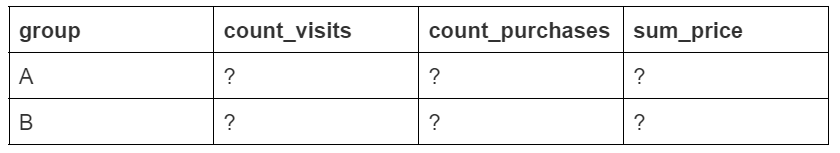
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
#ваш код здесь
#группировка и расчет показателей по группам
date_grouped = updated_data.groupby('group').agg({
    'user_id':'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})

print(date_grouped)
print('Задание 7.5.')
print(f"в группе А: {date_grouped[date_grouped['group'] == 'A']['count_visits'].iloc[0]} заходов")
print(f"в группе B: {date_grouped[date_grouped['group'] == 'B']['count_visits'].iloc[0]} заходов")

  group  count_visits  count_purchases   sum_price
0     A        145307            17487  1417780000
1     B        145381            17290  1533010000
Задание 7.5.
в группе А: 145307 заходов
в группе B: 145381 заходов


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

ваши выводы здесь

количество наблюдений совоставимо, разница менее 100.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
#ваш код здесь
#расчет конверсии ис среднего чека
date_grouped['conversion'] = date_grouped['count_purchases'] / date_grouped['count_visits']
date_grouped['mean_check'] = date_grouped['sum_price'] / date_grouped['count_purchases']

print('Задание 7.6')
print(f"конверсия в A: {round(100 * date_grouped[date_grouped['group'] == 'A']['conversion'].iloc[0], 2)} %")
print(f"конверсия в B: {round(100 * date_grouped[date_grouped['group'] == 'B']['conversion'].iloc[0], 2)} %")
print(f"средний чек в A: {int(round(date_grouped[date_grouped['group'] == 'A']['mean_check'].iloc[0], 0))} руб")
print(f"средний чек в B: {int(round(date_grouped[date_grouped['group'] == 'B']['mean_check'].iloc[0], 0))} руб")

Задание 7.6
конверсия в A: 12.03 %
конверсия в B: 11.89 %
средний чек в A: 81076 руб
средний чек в B: 88665 руб


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

ваши выводы здесь

При простом взятии среднего A эффективнее B по конверсии, а B эффективнее A по среднему чеку.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
#ваш код здесь
#сводная таблицы
pivot_data = updated_data[updated_data['purchase'] == 1].pivot_table(
    values='purchase',
    index='price',
    columns='group',
    aggfunc='sum',
).round()

print(pivot_data)

group      A     B
price             
10000   5182  5201
60000   5271  1730
100000  1832  5227
150000  3478  3438
200000  1724  1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

человек в группе A за 60 000 рублей: 5271
человек в группе B за 60 000 рублей: 1730


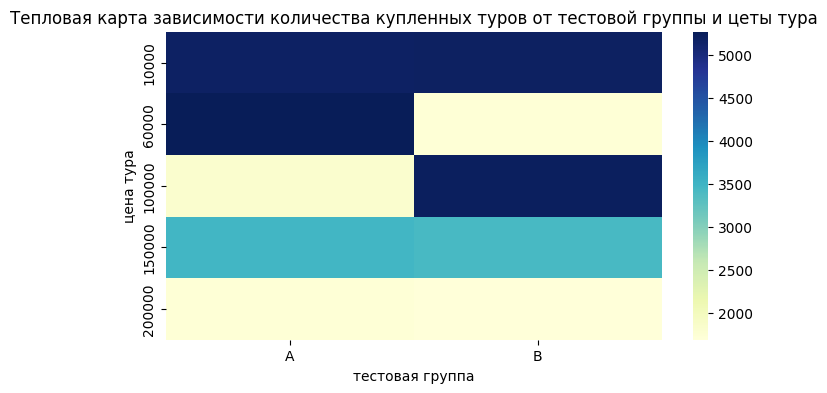

In [11]:
#ваш код здесь
#Задание 7.7 Теперь давайте сравним варианты по покупательской способности туров.
#Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура.
#Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией.
#Чему равно количество проданных туров за 60 000 рублей в группах?

print(f"человек в группе A за 60 000 рублей: {pivot_data['A'].loc[60000]}")
print(f"человек в группе B за 60 000 рублей: {pivot_data['B'].loc[60000]}")

#Построение тепловой карты по своднику
fig = plt.figure(figsize=(8, 4))
heatmap = sns.heatmap(data=pivot_data, cmap='YlGnBu')
heatmap.set_title('Тепловая карта зависимости количества купленных туров от тестовой группы и цеты тура')
heatmap.set_ylabel('цена тура')
heatmap.set_xlabel('тестовая группа');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

ваши выводы здесь

В Группе A покупательская способность заметно выше в категории "60 000 рублей".

В Группе B покупательская способность заметно выше в категории "100 000 рублей".

В данных группах разница в купленных турах кратная (в 2,5-3 раза). В остальных группах разница - несколько десятков человек (доли процентов продаж).

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
#ваш код здесь
#сводная таблица
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_revenue'
})

#вычисляем ежедневную конверсию и средний чек
daily_data['conversion'] = 100 * daily_data['count_purchases'] / daily_data['count_visits']
daily_data['avg_price'] = daily_data['sum_revenue'] / daily_data['count_purchases']

print(daily_data.head())

data_day = daily_data[daily_data['date'] == '2021-01-03']

print(f"Задание 7.8:")
print(f"конверсия 03.01.2021 в группе A: {round(data_day[data_day['group'] == 'A']['conversion'].iloc[0], 2)} %")
print(f"конверсия 03.01.2021 в группе B: {round(data_day[data_day['group'] == 'B']['conversion'].iloc[0], 2)} %")

print(f"средний чек 03.01.2021 в группе A: {int(round(data_day[data_day['group'] == 'A']['avg_price'].iloc[0], 0))} руб")
print(f"средний чек 03.01.2021 в группе B: {int(round(data_day[data_day['group'] == 'B']['avg_price'].iloc[0], 0))} руб")

        date group  count_visits  count_purchases  sum_revenue  conversion  \
0 2021-01-02     A          2854              359     29410000   12.578837   
1 2021-01-02     B          2861              345     29660000   12.058721   
2 2021-01-03     A          6596              748     62000000   11.340206   
3 2021-01-03     B          6619              754     65960000   11.391449   
4 2021-01-04     A          6566              799     64250000   12.168748   

      avg_price  
0  81922.005571  
1  85971.014493  
2  82887.700535  
3  87480.106101  
4  80413.016270  
Задание 7.8:
конверсия 03.01.2021 в группе A: 11.34 %
конверсия 03.01.2021 в группе B: 11.39 %
средний чек 03.01.2021 в группе A: 82888 руб
средний чек 03.01.2021 в группе B: 87480 руб


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
#ваш код здесь

#вычисляем кумулятивную сумму количества посетителей
daily_data['cum_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
#вычисляем кумулятивную сумму числа транзакций
daily_data['cum_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
#вычисляем кумулятивную выручку
daily_data['cum_revenue'] = daily_data.groupby(['group'])['sum_revenue'].cumsum()

daily_data['cum_conv_sale'] = 100 * daily_data['cum_purchases'] / daily_data['cum_visits']
daily_data['cum_avg_revenue'] = daily_data['cum_revenue'] / daily_data['cum_purchases']

print('Задание 7.9')
print(f"""кумулятивная конверсия в группе B на 20 января: {
    round(daily_data['cum_conv_sale'][(daily_data['group'] == 'B') & (daily_data['date'] == '2021-01-20')].iloc[0], 2)
}%""")
print(f"""кумулятивный средний чек в группе А на 12 января 2021 года: {
    int(round(daily_data['cum_avg_revenue'][(daily_data['group'] == 'A') & (daily_data['date'] == '2021-01-12')].iloc[0], 0))
}""")

Задание 7.9
кумулятивная конверсия в группе B на 20 января: 11.9%
кумулятивный средний чек в группе А на 12 января 2021 года: 81492


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

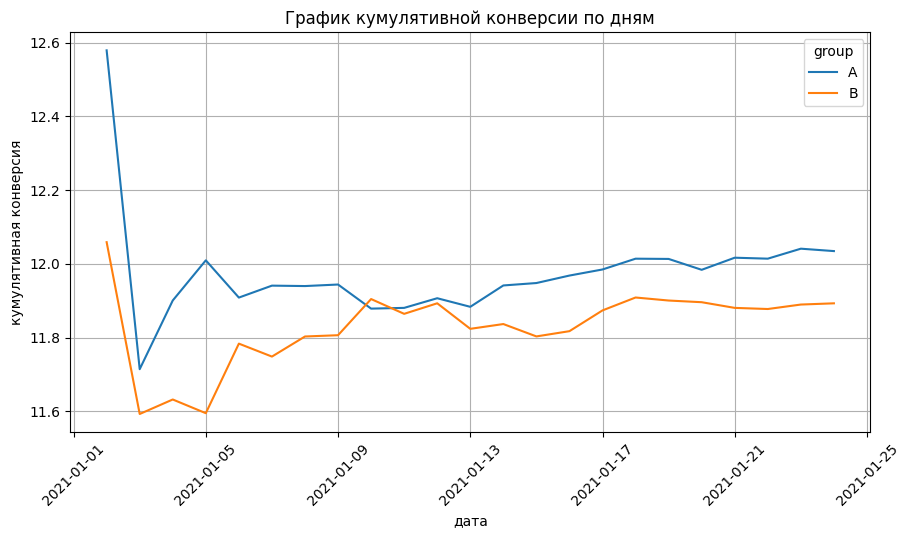

In [14]:
#ваш код здесь
#создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
#добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
#строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conv_sale', data=daily_data, hue='group', ax=ax)
#задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
#задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
#задаем подписи осей
ax.set_xlabel('дата')
ax.set_ylabel('кумулятивная конверсия')
#задаём отображение сетки
ax.grid(True);

ваши выводы здесь

Конверсия группы B стабильно хуже конверсии группы А практически на всём промежутке времени, за исключением одного дня 10.01.2021 - можно сказать, что метрики стабилизаровлись после этой даты, вертикальное расстояние между кривыми по группам стабилизировалось. Однако разница составляет десятые доли процентного пункта. При дальнейшей проверке мы можем получить незначимость такой разницы конверсий.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [15]:
#ваш код здесь
conversion_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
print(conversion_piv)

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=conversion_piv['sum'], #число "успехов"
    nobs=conversion_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
    print("полученное p_value < alpha")
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
    print("полученное p_value > alpha")

         sum   count
group               
A      17487  145307
B      17290  145381
p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны
полученное p_value > alpha


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

При уровне значимости 5% истинные значения конверсий в группах равны, разница в метрике в группах статистически не значима.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [16]:
# ваш код здесь
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

def proportions_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

Доверительные интервалы для конверсий по группам перекрываются, доверительный интервал для разности конверсий включает в себя 0 - отсутствие разницы между конверсиями в группах А и B подтверждается. 

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

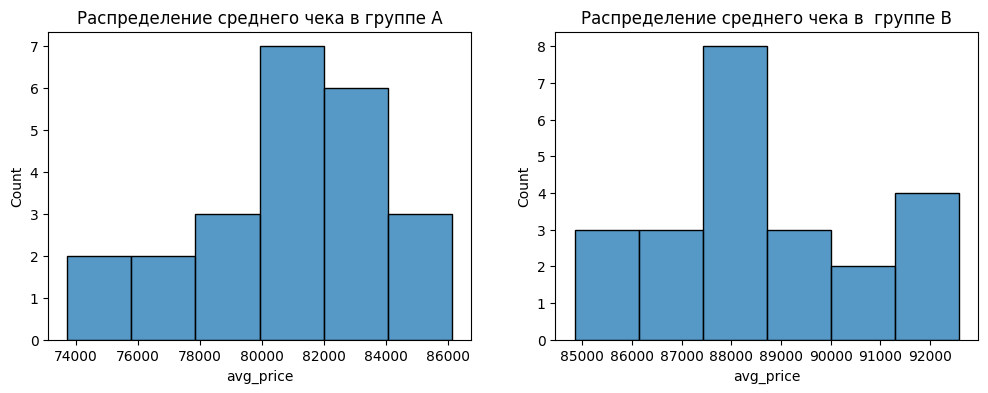

p-value группы А 0.25
p-value группы B 0.09
По группе А принимаем нулевую гипотезу. Распределение нормальное
По группе B принимаем нулевую гипотезу. Распределение нормальное


In [17]:
# ваш код здесь

daily_data.head()

#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='avg_price', data=daily_data[daily_data['group'] == 'A'], ax=axes[0])
sns.histplot(x='avg_price', data=daily_data[daily_data['group'] == 'B'], ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А')
axes[1].set_title('Распределение среднего чека в  группе B')
plt.show()

H0 = 'Распределение нормальное'
H1 = 'Распределениеотлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data['avg_price'][daily_data['group'] == 'A'])
shapiro_result_b = shapiro(daily_data['avg_price'][daily_data['group'] == 'B'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha:
    print("По группе А отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("По группе А принимаем нулевую гипотезу. {}".format(H0))
    
if shapiro_result_b.pvalue < alpha:
    print("По группе B отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("По группе B принимаем нулевую гипотезу. {}".format(H0))

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [18]:
# ваш код здесь
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data['avg_price'][daily_data['group'] == 'A'],
    b=daily_data['avg_price'][daily_data['group'] == 'B'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
    print('pvalue < alpha')
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
    print('pvalue > alpha')

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B
pvalue < alpha


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

ваши выводы здесь

Статистическая разница в чеках есть: ежедневный средний чек в группе А меньше, чем в группе B.

Такой результат хотелось видеть, т.к. к группе B все же покупали более дорогие путевки (согласно п.7.7).

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [19]:
# ваш код здесь
alpha = 0.05 #100%-95%
def interval_calc(group):
    #отбор базы
    data_for_interval = daily_data['avg_price'][daily_data['group'] == group]
    
    #t критическое
    t_crit = -t.ppf(alpha/2, data_for_interval.shape[0] - 1)
    #выборочное стандартное отклонение
    std_calc = data_for_interval.std()
    # погрешность
    err = t_crit * std_calc/(data_for_interval.shape[0] ** 0.5)
    lower_bound = round(data_for_interval.mean() - err) # левая (нижняя) граница
    upper_bound = round(data_for_interval.mean() + err) # правая (верхняя) граница
    print(f"группа {group}: ({lower_bound} - {upper_bound})")

interval_calc(group = 'A')
interval_calc(group = 'B')

группа A: (79630 - 82308)
группа B: (87626 - 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

ваши выводы здесь

Не только средний чек в группах разный. Доверительные интервалы для среднего чека тоже не пересекаются. Так и ожидалось, так как разница в среднем чеке из предыдущего упражнения тоже была значима.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему?

Так как уровни конверсии по группам статистически незначимы, а средний чек в группе B значимо выше, то посадочная страница для группы B более эффективна.

Так как разница в среднем чеке достигается за счет перевеса туров за 100000 в Тайланд в группе B над турами за 60000 в Турцию в группе A, а Тайланд идет выше Турции по алфавиту, то неужели просто рассортировали страны на странице по алфавиту так, чтобы, скажем, Турция оказывалась ниже Тайланда или вообще была видна толкьо после перемотки вниз?..